# 环境

In [1]:
import os, subprocess
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import trange
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF_F
from torchvision.utils import make_grid

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d.axes3d import Axes3D, art3d
from matplotlib.patches import Circle

# stable outputs across different runs
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# get device to calculate on (either CPU or GPU with minimum memory load)
def get_gpu_memory_map():
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    
    return gpu_memory_map

# 自动获取占用最少的gpu进行计算
def get_device():
    if torch.cuda.is_available():
        memory_map = get_gpu_memory_map()
        device = "cuda:%d" % min(memory_map, key=memory_map.get)
    else:
        device = "cpu"
    
    print("Device:", device)
    return device

device = get_device()

Device: cuda:1


# supervise cnn ae模型结构

In [2]:
# Here We defined three convolutional layers for authoencoder
# each cnn layer contains: "conv2","BatchNorm2d" and  Relu activation function
n_layers='5_layer'
# implement autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 12, kernel_size=4, stride=2, padding=1), #3x32x32 to 12x16x16
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1), #12x16x16 to 24x8x8
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1), #24x8x8 to 48x4x4
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1), #48x4x4 to 96x2x2
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 192, kernel_size=4, stride=2, padding=1), #96x2x2 to 192x1x1
            nn.BatchNorm2d(192),
            nn.ReLU()
        )

        # kjl多加一个类别层
        self.classifier = nn.Sequential(
            nn.Linear(192, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(192, 96, kernel_size=4, stride=2, padding=1, output_padding=0), #192x1x1 to 96x2x2
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, kernel_size=4, stride=2, padding=1, output_padding=0), #96x2x2 to 48x4x4
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1, output_padding=0), #48x4x4 to 24x8x8
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1, output_padding=0), #24x8x8 to 12x16x16
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1, output_padding=0), #12x16x16 to 3x32x32
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
  # defined the forward function to take input
  # call the encoder to encod the input
  # call the decoder function to decode the encoded inpu
    def forward(self, x):
        encoded = self.encoder(x)

        temp = encoded # 层数最高的卷积
        emb = temp.view(encoded.size(0), -1) #flatten
        pre = self.classifier(emb)

        decoded = self.decoder(encoded)
        return encoded, decoded, pre

    #with an pooling on output of trained encoder we have an embeding vector for each image 
    #this vector can used for MLP or other method for prediction
    def embedding(self,x):
        encoded = self.encoder(x)
        # encoded = nn.AvgPool2d(2,2)(encoded) #48*4*4-->48x2x2 embedded features # 层数最高的卷积不能有这个
        encoded = encoded.view(encoded.size(0), -1)   #flatten 48x2x2->192
        return encoded

# 采样算法

In [3]:
import random
import numpy as np
from scipy.spatial.distance import cdist
import os   
import cffi
import sys
import time
import math
import functools


blue_noise_fail_rate = 0.1

# 采样算法的父类
class SamplingBase(object):
    def __init__(self, sampling_rate):
        self.sampling_rate = sampling_rate
        return

    def sample(self, data, category):
        raise NotImplementedError("Sampling not implemented")

# 打网格的密度采样(从原始数据中获取子集)
class NonUniformSampling(SamplingBase):
    def __init__(self, sampling_rate, grid_size=100):
        super(NonUniformSampling, self).__init__(sampling_rate)
        self.grid_size = grid_size
        return

    def sample(self, data, category=None):
        '''
            注意data是归一化后的2维坐标数据：[0, 1] × [0, 1]
        '''
        
        n = data.shape[0] # 原始空间中样本的数量
        m = round(n * self.sampling_rate)

        grid_count, grid_indexes = self._construct_grids(data, self.grid_size)
        sample_count = np.ceil(grid_count * self.sampling_rate).astype(int)
        non_empty_grids = np.sum(sample_count > 0)
        max_represneted_density = int(m * 2 / non_empty_grids)
        density_count = np.bincount(grid_count.reshape(-1))
        k = non_empty_grids / max_represneted_density
        tmp = 0
        next_milestone = k
        flag = True
        tmp_density = 1
        density_to_represent = [0]
        for grid_this_density in density_count[1:]:
            # if grid_this_density == 0:
            #     density_to_represent.append(-1)
            #     continue
            if tmp + grid_this_density <= next_milestone:
                density_to_represent.append(tmp_density)
                flag = False
            else:
                if next_milestone - tmp > tmp + grid_this_density - next_milestone or flag:
                    density_to_represent.append(tmp_density)
                    tmp_density += 1
                    flag = True
                else:
                    tmp_density += 1
                    density_to_represent.append(tmp_density)
                    flag = False
                next_milestone += k
            tmp += grid_this_density
        selected_indexes = []
        

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if grid_count[i][j] > 0:
                    this_select = np.random.choice(grid_count[i][j], density_to_represent[grid_count[i][j]], replace=False)
                    # this_select = np.random.choice(grid_count[i][j], sample_count[i][j], replace=False)
                    selected_indexes.append([grid_indexes[i][j][t] for t in this_select])
        selected_indexes = np.concatenate(selected_indexes)
        return selected_indexes

    def _construct_grids(self, data, grid_size):
        # 代码将输入数据乘以grid_size并转换为整数类型，得到离散化的数据discrete_full_data。这样做的目的是将数据映射到网格的坐标空间上。
        discrete_full_data = (data * grid_size).astype(int)
        # 通过np.where函数找到位于网格边界的数据点，并将其坐标减去1。这是为了保证所有数据点都在网格范围内，避免越界。
        discrete_full_data[np.where(discrete_full_data == grid_size)] -= 1
        # 代码创建了两个空数组：grid_count和grid_indexes。grid_count是一个大小为(grid_size, grid_size)的二维数组，用于统计每个网格中的数据点数量。grid_indexes是一个嵌套的二维列表，用于存储每个网格中数据点的索引。
        grid_count = np.zeros((grid_size, grid_size)).astype(int)
        grid_indexes = [[[] for _ in range(grid_size)] for __ in range(grid_size)]
        
        for k, single_data in enumerate(discrete_full_data):
            grid_count[single_data[0], single_data[1]] += 1
            grid_indexes[single_data[0]][single_data[1]].append(k)
        return grid_count, grid_indexes




# 加载训练好的ae

In [4]:
AE = Autoencoder()
AE = AE.to(device)
AE.load_state_dict(torch.load("./model_files/CIFAR10/checkpoints/supervised_cnn_ae/5_layer_autoencoder_adam_lr=0.001_cl_weight=1_recon_weight=1_torch.Size([128, 192]).pkl", map_location=device))
AE.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_featu

# 降维原始采样的图片

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image 

# 自定义datasets
class My_pics_data_sets(Dataset):
    def __init__(self, path, transform=None):
        super(My_pics_data_sets, self).__init__()
        self.root_dir = path
        self.img_names = os.listdir(self.root_dir)
        self.img_names.sort(key = lambda x : int(x[4:-4]))
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img = Image.open(os.path.join(self.root_dir, img_name))
        id_name = torch.tensor(int(img_name[4:-4])) #pic_xx.jpg
        if self.transform is not None:
            img = self.transform(img)
        return img, id_name

    def __len__(self):
        return len(self.img_names)

class FloatTransformer(object):
    def __call__(self, tensor):
        return tensor.type(torch.FloatTensor)
ae_transfrom = transforms.Compose([transforms.ToTensor(),
                            FloatTransformer(), #[0,255]->[0,1]
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# 加载数据集
pics_datasets = My_pics_data_sets("./static/data/CIFAR10/pic/random_50k_png/", ae_transfrom)
pics_dataloader = torch.utils.data.DataLoader(
                dataset=pics_datasets,
                batch_size=128,
                shuffle=False)
labels = torch.load("./static/data/CIFAR10/labels/BigGAN_random_png_208z_50000_2023-08-30_labels.pt", map_location=device)
labels = labels.detach().cpu()

# 使用AE进行降维
model = AE
model.eval()
num = 0
with torch.no_grad():
    for pics, ids in pics_dataloader:
        pics = pics.to(device)
        z = model.embedding(pics)
        if num == 0:
            zs = z
            # all_pics = pics
            num = 1
            print("ids: ", ids)
        else:
            zs = torch.cat((zs, z), dim = 0)
            # all_pics = torch.cat((all_pics, pics), dim = 0)

print("降维之前zs.shape：", zs.shape)
# 可能比较耗时
from openTSNE import TSNE
zs = zs.detach().cpu()
zs = TSNE(n_jobs=4).fit(zs)  # 输出N, 2
print("降维之后zs.shape：", zs.shape)

ids:  tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127])
降维之前zs.shape： torch.Size([50000, 192])
降维之后zs.shape： (50000, 2)


# 原始空间散点图绘制

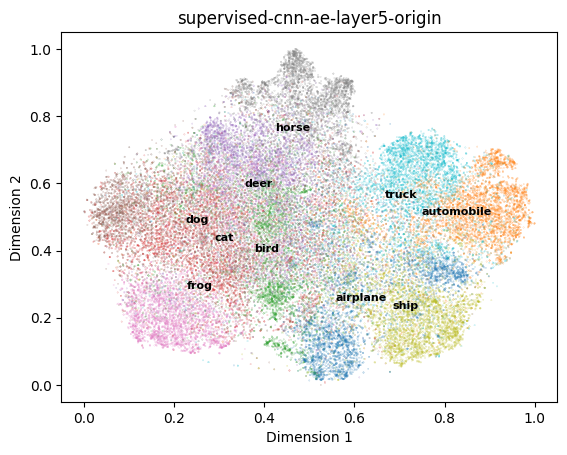

In [6]:

# 绘制散点图
import torch
import numpy as np
import matplotlib.pyplot as plt

# labels = torch.load("./临时垃圾-随时可删/labels.pt")
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

title = f"supervised-cnn-ae-layer5-origin"

# 进行归一化到[0,1]*[0,1]
zs_np = zs
# np.max(array1, axis=0)的意思就是：按第一个维度（即，行）对array1进行拆分，得到array1[0, :]、array1[1, :]、array1[2, :]，然后对array1[0, :]、array1[1, :]、array1[2, :]的对应元素进行逐位比较，并取其最大者，构成新的ndarray。
min_val = np.min(zs_np, axis=0)
max_val = np.max(zs_np, axis=0)
zs_np = (zs_np - min_val) / (max_val - min_val) 

# 获取类别数量和颜色映射
color_map = plt.get_cmap("tab10")

# 绘制散点图
plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.01, c=labels, cmap=color_map)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(title)
# plt.colorbar(label="Class")

# 添加类别标签
for i in range(10):
    label = cifar10_labels[i]
    x = zs_np[labels == i, 0].mean()
    y = zs_np[labels == i, 1].mean()
    plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')
plt.show()

# 原始数据采样测试（直接使用shixialiu的代码）

采样后的长度： 40860


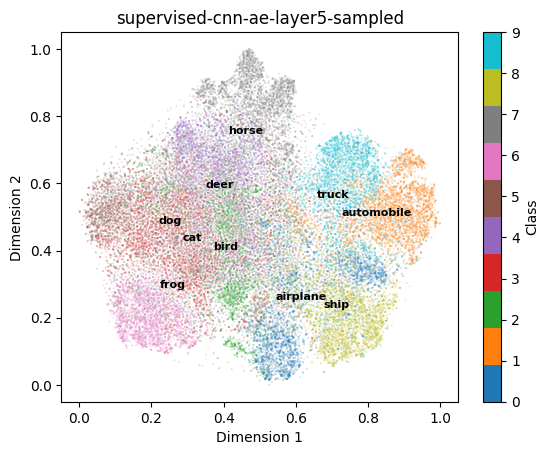

In [7]:
origin_sample = NonUniformSampling(0.8)
sampled_index = origin_sample.sample(zs_np)
print("采样后的长度：", len(sampled_index))

sampled_zs_np = zs_np[sampled_index]
sampled_labels = labels[sampled_index]

# labels = torch.load("./临时垃圾-随时可删/labels.pt")
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

title = f"supervised-cnn-ae-layer5-sampled"

# 进行归一化到[0,1]*[0,1]
min_val = np.min(sampled_zs_np, axis=0)
max_val = np.max(sampled_zs_np, axis=0)
sampled_zs_np = (sampled_zs_np - min_val) / (max_val - min_val) 

# 获取类别数量和颜色映射
color_map = plt.get_cmap("tab10")

# 绘制散点图
plt.scatter(sampled_zs_np[:, 0], sampled_zs_np[:, 1], s=0.01, c=sampled_labels, cmap=color_map)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(title)
plt.colorbar(label="Class")

# 添加类别标签
for i in range(10):
    label = cifar10_labels[i]
    x = sampled_zs_np[sampled_labels == i, 0].mean()
    y = sampled_zs_np[sampled_labels == i, 1].mean()
    plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')
plt.show()

# 原始数据采样测试，修改了shixialiu的代码

采样后的长度： 50000


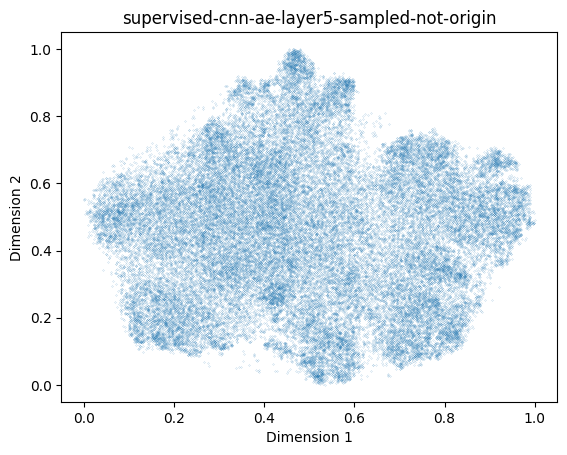

In [8]:
# 打网格的密度采样，不再是从原始数据集中获取子集，而是采取新的坐标点
class density_based_latent_space_sampling():
    def __init__(self, sampling_number=50000, grid_size=100):
            super(density_based_latent_space_sampling, self).__init__()
            '''
                sampling_number：采样的数量
                grid_size：划分网格（grid_size*grid_size）
            '''
            self.sampling_number = sampling_number
            self.grid_size = grid_size
            return

    # 采样
    def sample(self, data):
        '''
            注意data是归一化后的2维坐标数据：[0, 1] × [0, 1]
        '''

        # 获取数据样本数量
        n = data.shape[0]
        
        # 构建网格，返回每个网格中的样本数量，以及样本下标
        grid_count, grid_indexes = self._construct_grids(data, self.grid_size)

        # 计算每个网格的采样数量
        sample_count = np.ceil(grid_count * self.sampling_number / n).astype(int)

        # 统计非空网格的数量
        non_empty_grids = np.sum(sample_count > 0)

        # 计算每个网格最大代表密度(这个乘以2好像就是为了扩大一下差异，经验数值，来自gpt)
        max_represneted_density = int(self.sampling_number * 2 / non_empty_grids)

        # 统计每个代表密度级别的网格数量(返回一个数组，其长度等于grid_count中元素最大值加1，每个元素值则是它当前索引值在grid_count中出现的次数)
        density_count = np.bincount(grid_count.reshape(-1))

        # 计算密度级别之间的间隔
        k = non_empty_grids / max_represneted_density

        tmp = 0 # 用于临时计数
        next_milestone = k # 下一个密度里程碑
        flag = True # 标记是否需要增加密度级别
        tmp_density = 1 # 当前密度级别
        density_to_represent = [0] # 特定数据含量的网格所代表的密度级别
        for grid_this_density in density_count[1:]:
            # if grid_this_density == 0:
            #     density_to_represent.append(-1)
            #     continue
            # 如果当前密度级别的网格数量加上当前计数小于等于下一个里程碑，则将当前密度级别添加到密度代表列表中
            if tmp + grid_this_density <= next_milestone:
                density_to_represent.append(tmp_density)
                flag = False
            else:
                # 如果下一个里程碑减去当前计数大于当前计数加上当前密度级别的网格数量减去下一个里程碑，或者flag为True，则将当前密度级别添加到密度代表列表中
                if next_milestone - tmp > tmp + grid_this_density - next_milestone or flag:
                    density_to_represent.append(tmp_density)
                    tmp_density += 1
                    flag = True
                else:
                    tmp_density += 1
                    density_to_represent.append(tmp_density)
                    flag = False
                next_milestone += k
            tmp += grid_this_density

        all_coordinates = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if grid_count[i][j] > 0:
                    # 从当前网格中根据密度级别随机生成数据
                    x_min, x_max = i*1/self.grid_size, (i+1)/self.grid_size
                    y_min, y_max = j*1/self.grid_size, (j+1)/self.grid_size
                    # 生成随机二维坐标数组
                    coordinates = np.random.uniform(low=[x_min, y_min], high=[x_max, y_max], size=(density_to_represent[grid_count[i][j]], 2))
                    all_coordinates.append(coordinates)
        
        all_coordinates = np.concatenate(all_coordinates, axis=0)
        return all_coordinates

    # 构建网格
    def _construct_grids(self, data, grid_size):
        '''
            返回值：
            grid_count：统计每个网格中的样本数量
            grid_indexes：记录每个网格中的样本的下标
        '''
        # 代码将输入数据乘以grid_size并转换为整数类型，得到离散化的数据discrete_full_data。这样做的目的是将数据映射到网格的坐标空间上。
        discrete_full_data = (data * grid_size).astype(int)
        # 通过np.where函数找到位于网格边界的数据点，并将其坐标减去1。这是为了保证所有数据点都在网格范围内，避免越界。
        discrete_full_data[np.where(discrete_full_data == grid_size)] -= 1
        # 代码创建了两个空数组：grid_count和grid_indexes。grid_count是一个大小为(grid_size, grid_size)的二维数组，用于统计每个网格中的数据点数量。grid_indexes是一个嵌套的二维列表，用于存储每个网格中数据点的索引。
        grid_count = np.zeros((grid_size, grid_size)).astype(int)
        grid_indexes = [[[] for _ in range(grid_size)] for __ in range(grid_size)]
        
        for k, single_data in enumerate(discrete_full_data):
            grid_count[single_data[0], single_data[1]] += 1
            grid_indexes[single_data[0]][single_data[1]].append(k)
        return grid_count, grid_indexes

# 打网格的密度采样，简化版本
class density_based_latent_space_sampling_simply():
    def __init__(self, sampling_number=50000, grid_size=100):
            super(density_based_latent_space_sampling_simply, self).__init__()
            '''
                sampling_number：采样的数量
                grid_size：划分网格（grid_size*grid_size）
            '''
            self.sampling_number = sampling_number
            self.grid_size = grid_size
            return

    # 采样
    def sample(self, data):
        '''
            注意data是归一化后的2维坐标数据：[0, 1] × [0, 1]
        '''

        # 获取数据样本数量
        n = data.shape[0]
        
        # 构建网格，返回每个网格中的样本数量，以及样本下标
        grid_count, grid_indexes = self._construct_grids(data, self.grid_size)

        # 计算每个网格的采样数量
        sample_count = np.ceil(grid_count * self.sampling_number / n).astype(int)

        all_coordinates = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if grid_count[i][j] > 0:
                    # 从当前网格中根据密度级别随机生成数据
                    x_min, x_max = i*1/self.grid_size, (i+1)/self.grid_size
                    y_min, y_max = j*1/self.grid_size, (j+1)/self.grid_size
                    # 生成随机二维坐标数组
                    coordinates = np.random.uniform(low=[x_min, y_min], high=[x_max, y_max], size=(sample_count[i][j], 2))
                    all_coordinates.append(coordinates)
        
        all_coordinates = np.concatenate(all_coordinates, axis=0)
        return all_coordinates

    # 构建网格
    def _construct_grids(self, data, grid_size):
        '''
            返回值：
            grid_count：统计每个网格中的样本数量
            grid_indexes：记录每个网格中的样本的下标
        '''
        # 代码将输入数据乘以grid_size并转换为整数类型，得到离散化的数据discrete_full_data。这样做的目的是将数据映射到网格的坐标空间上。
        discrete_full_data = (data * grid_size).astype(int)
        # 通过np.where函数找到位于网格边界的数据点，并将其坐标减去1。这是为了保证所有数据点都在网格范围内，避免越界。
        discrete_full_data[np.where(discrete_full_data == grid_size)] -= 1
        # 代码创建了两个空数组：grid_count和grid_indexes。grid_count是一个大小为(grid_size, grid_size)的二维数组，用于统计每个网格中的数据点数量。grid_indexes是一个嵌套的二维列表，用于存储每个网格中数据点的索引。
        grid_count = np.zeros((grid_size, grid_size)).astype(int)
        grid_indexes = [[[] for _ in range(grid_size)] for __ in range(grid_size)]
        
        for k, single_data in enumerate(discrete_full_data):
            grid_count[single_data[0], single_data[1]] += 1
            grid_indexes[single_data[0]][single_data[1]].append(k)
        return grid_count, grid_indexes


# 画图展示
origin_sample = density_based_latent_space_sampling_simply(sampling_number=50000)
sampled_coordinates = origin_sample.sample(zs_np)
print("采样后的长度：", len(sampled_coordinates))

sampled_zs_np = sampled_coordinates

title = f"supervised-cnn-ae-layer5-sampled-not-origin"

# 进行归一化到[0,1]*[0,1]
min_val = np.min(sampled_zs_np, axis=0)
max_val = np.max(sampled_zs_np, axis=0)
sampled_zs_np = (sampled_zs_np - min_val) / (max_val - min_val) 

# 获取类别数量和颜色映射
color_map = plt.get_cmap("tab10")

# 绘制散点图
plt.scatter(sampled_zs_np[:, 0], sampled_zs_np[:, 1], s=0.01)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(title)

plt.show()

# 为原始空间建立kd搜索树

In [9]:
from scipy import spatial
tree = spatial.KDTree(data=zs_np)

# 根据采样的2D坐标生成图片

In [61]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.utils as utils
import numpy as np
from scipy.stats import norm
import torch

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all

import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import fid_score as official_fid


# 最开始的版本，就取近邻的向量进行插值，但是不对类的向量进行插值
def get_zs_new_not_class(coordinates, kdTree_2D, latent_z, k=12):
    '''
    coordinates: n个要插值的坐标
    kdTree_2D: 降维后的2D坐标
    latent_z: 生成模型的输入潜向量，和kdTree_2D是一一对应关系
    k: 近邻的数量
    '''
    print("最开始的版本，优化了一下代码~~~~~~~~~~~ k:",k)
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k) #这里的k为固定值
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    
    for iter in range(len(coordinates)):
        iter_distance = nearest_distance[iter]
        iter_index = nearest_index[iter]
        
        sum_distanceForIter = np.sum(iter_distance) #这k个近邻的距离总和
        for i, index in enumerate(iter_index):
            temp_z = latent_z[index].clone().detach()
            temp_distance = iter_distance[i]
            w = (sum_distanceForIter-temp_distance)/((k-1)*sum_distanceForIter) #对z进行权重
            if i == 0:
                z = temp_z*w
            else:
                z += temp_z*w

        z[-128:] = latent_z[iter_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量

        z = z.unsqueeze(0) # shape:[1*latent_dim]
        if iter == 0:
            zs = z
        else:
            zs = torch.cat((zs, z), dim=0)
        # print(zs.shape)
    return zs

# 插值函数(kjl的防止粘贴函数)
def get_zs_prevent_stick(coordinates, kdTree_2D, latent_z, k=12):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

# 插值函数，最远最近插值方法
def get_zs_farthest_and_closeet(coordinates, kdTree_2D, latent_z, k=50000):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了最近最远插值~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的距离
        most_nearst_dis = pos_nearst_distance[0]

        # 最远点的的距离
        most_farthest_dis = pos_nearst_distance[-1]

        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[-1]].clone().detach()
        sum_distance = most_nearst_dis + most_farthest_dis
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-most_farthest_dis)/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

# 插值函数，反距离权重插值
def get_zs_idw(coordinates, kdTree_2D, latent_z, k=3, p=8):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了反距离权重插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]
        weights = torch.tensor(1.0 / (pos_nearst_distance + 1e-8)) # 避免除以零，加上一个小的常数

        # 计算加权平均
        weighted_values = latent_z[pos_nearst_index].clone().detach() * weights[:, None] ** p
        z_new = torch.sum(weighted_values, dim=0) / torch.sum(weights**p)
        
        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

# 插值函数，反距离权重插值
def get_zs_idw_not_class(coordinates, kdTree_2D, latent_z, k=3, p=8):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了反距离权重插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]
        weights = torch.tensor(1.0 / (pos_nearst_distance + 1e-8)) # 避免除以零，加上一个小的常数

        # 计算加权平均
        weighted_values = latent_z[pos_nearst_index].clone().detach() * weights[:, None] ** p
        z_new = torch.sum(weighted_values, dim=0) / torch.sum(weights**p)
        

        z_new[-128:] = latent_z[pos_nearst_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量
        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs


# 用来处理zs的类，方便使用batchsize
class My_2D_zs_data_sets(Dataset):
    def __init__(self, zs):
        super(My_2D_zs_data_sets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)

# 数据集
new_coords = sampled_coordinates
kdTree = tree
latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错

zs_2D = get_zs_idw(new_coords, kdTree, latent_z)

zs_datasets = My_2D_zs_data_sets(zs_2D)
zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)


checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
G = model_all.get_generative_model("CIFAR10").to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()

first = 0 # 判断是否第一次进入循环
count = 0
print("生成图片中。。。。")
with torch.no_grad(): # 取消梯度计算，加快运行速度
    for batch_z in zs_loader: 
        z = batch_z.clone().to(torch.float32).to(device)    # latent code
        imgs = G(z)   
        for i, img in enumerate(imgs):
            img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
            utils.save_image(img.detach().cpu(), f'./static/data/CIFAR10/pic/2D_50k_png/pic_{count}.png')
            count += 1
print("图片生成完成。。。。")

进入了反距离权重插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。


# 计算IS值

In [62]:
# 使用inception_v3获取
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
import torch.nn.functional as F

# 加载预训练的Inception模型
inception_model = inception_v3(pretrained=True, transform_input=False).eval()
device = torch.device("cuda:1")
inception_model.to(device)


# 生成的图像数据集（假设你有一个名为generated_data的数据集）
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
generated_dataset = My_pics_data_sets(path="./static/data/CIFAR10/pic/2D_50k_png/",transform=transform)
generated_dataloader = DataLoader(generated_dataset, batch_size=32, shuffle=True)

# 计算预测分数
predictions = []
for images, ids in generated_dataloader:
    images = images.to(device)
    with torch.no_grad():
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        preds = inception_model(images)
    predictions.append(torch.softmax(preds, dim=1))

predictions = torch.cat(predictions, dim=0)
print("predictions.shape: ", predictions.shape)

fake_probs = predictions
# fake_probs.mean(dim=0, keepdim=True).shape
# 计算Inception Score
kl_divergence = (fake_probs * (fake_probs / fake_probs.mean(dim=0, keepdim=True)).log()).sum(dim=1)
print(kl_divergence.shape)
inception_score = torch.exp(kl_divergence.mean()).item()
print("Inception Score:", inception_score)

predictions.shape:  torch.Size([50000, 1000])
torch.Size([50000])
Inception Score: 8.614921569824219


# 计算fid值

In [64]:
# fid计算模型
dims = 2048
batch_size = 1
num_avail_cpus = len(os.sched_getaffinity(0))
num_workers = min(num_avail_cpus, 8)
block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
fid_model = official_fid.InceptionV3([block_idx], normalize_input=False).to(device)
# fid_model = official_fid.InceptionV3([block_idx]).to(device)
print('fid_model load success!')


pic_path_fid1 = './static/data/CIFAR10/pic/origin_50k_png'
pic_path_fid2 = './static/data/CIFAR10/pic/2D_50k_png'

    
batch_size = 100
m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                    dims, device, num_workers)
m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                    dims, device, num_workers)
fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
print(fid_value)

fid_model load success!


100%|██████████| 500/500 [00:52<00:00,  9.55it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
6.291082419876091


# 不同近邻个数的评估

In [70]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.utils as utils
import numpy as np
from scipy.stats import norm
import torch

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all

import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import fid_score as official_fid


# 最开始的版本，就取近邻的向量进行插值，但是不对类的向量进行插值
def get_zs_new_not_class(coordinates, kdTree_2D, latent_z, k=12):
    '''
    coordinates: n个要插值的坐标
    kdTree_2D: 降维后的2D坐标
    latent_z: 生成模型的输入潜向量，和kdTree_2D是一一对应关系
    k: 近邻的数量
    '''
    print("最开始的版本，优化了一下代码~~~~~~~~~~~ k:",k)
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k) #这里的k为固定值
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    
    for iter in range(len(coordinates)):
        iter_distance = nearest_distance[iter]
        iter_index = nearest_index[iter]
        
        sum_distanceForIter = np.sum(iter_distance) #这k个近邻的距离总和
        for i, index in enumerate(iter_index):
            temp_z = latent_z[index].clone().detach()
            temp_distance = iter_distance[i]
            w = (sum_distanceForIter-temp_distance)/((k-1)*sum_distanceForIter) #对z进行权重
            if i == 0:
                z = temp_z*w
            else:
                z += temp_z*w

        z[-128:] = latent_z[iter_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量

        z = z.unsqueeze(0) # shape:[1*latent_dim]
        if iter == 0:
            zs = z
        else:
            zs = torch.cat((zs, z), dim=0)
        # print(zs.shape)
    return zs

# 插值函数(kjl的防止粘贴函数)
def get_zs_prevent_stick(coordinates, kdTree_2D, latent_z, k=12):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

# 插值函数，最远最近插值方法
def get_zs_farthest_and_closeet(coordinates, kdTree_2D, latent_z, k=50000):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了最近最远插值~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的距离
        most_nearst_dis = pos_nearst_distance[0]

        # 最远点的的距离
        most_farthest_dis = pos_nearst_distance[-1]

        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[-1]].clone().detach()
        sum_distance = most_nearst_dis + most_farthest_dis
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-most_farthest_dis)/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

# 插值函数，反距离权重插值
def get_zs_idw(coordinates, kdTree_2D, latent_z, k=3, p=8):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了反距离权重插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]
        weights = torch.tensor(1.0 / (pos_nearst_distance + 1e-8)) # 避免除以零，加上一个小的常数

        # 计算加权平均
        weighted_values = latent_z[pos_nearst_index].clone().detach() * weights[:, None] ** p
        z_new = torch.sum(weighted_values, dim=0) / torch.sum(weights**p)
        
        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

# 插值函数，反距离权重插值，不对类别进行插值
def get_zs_idw_not_class(coordinates, kdTree_2D, latent_z, k=2, p=8):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了反距离权重插值，不对类别进行插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]
        weights = torch.tensor(1.0 / (pos_nearst_distance + 1e-8)) # 避免除以零，加上一个小的常数

        # 计算加权平均
        weighted_values = latent_z[pos_nearst_index].clone().detach() * weights[:, None] ** p
        z_new = torch.sum(weighted_values, dim=0) / torch.sum(weights**p)
        

        z_new[-128:] = latent_z[pos_nearst_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量
        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs


# 用来处理zs的类，方便使用batchsize
class My_2D_zs_data_sets(Dataset):
    def __init__(self, zs):
        super(My_2D_zs_data_sets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)

# 数据集
new_coords = sampled_coordinates
kdTree = tree
latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错


for p in [3, 5, 8, 10, 20, 30, 50, 80, 100]:

    zs_2D = get_zs_idw_not_class(new_coords, kdTree, latent_z , k=200, p=p)

    zs_datasets = My_2D_zs_data_sets(zs_2D)
    zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)


    checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
    G = model_all.get_generative_model("CIFAR10").to(device)
    G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
    G.eval()

    first = 0 # 判断是否第一次进入循环
    count = 0
    print("生成图片中。。。。")
    with torch.no_grad(): # 取消梯度计算，加快运行速度
        for batch_z in zs_loader: 
            z = batch_z.clone().to(torch.float32).to(device)    # latent code
            imgs = G(z)   
            for i, img in enumerate(imgs):
                img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
                utils.save_image(img.detach().cpu(), f'./static/data/CIFAR10/pic/2D_50k_png/pic_{count}.png')
                count += 1
    print("图片生成完成。。。。")


    # 使用inception_v3获取
    from torchvision.models import inception_v3
    from torch.utils.data import DataLoader
    import torch.nn.functional as F

    # 加载预训练的Inception模型
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    device = torch.device("cuda:1")
    inception_model.to(device)


    # 生成的图像数据集（假设你有一个名为generated_data的数据集）
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
    generated_dataset = My_pics_data_sets(path="./static/data/CIFAR10/pic/2D_50k_png/",transform=transform)
    generated_dataloader = DataLoader(generated_dataset, batch_size=32, shuffle=True)

    # 计算预测分数
    predictions = []
    for images, ids in generated_dataloader:
        images = images.to(device)
        with torch.no_grad():
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            preds = inception_model(images)
        predictions.append(torch.softmax(preds, dim=1))

    predictions = torch.cat(predictions, dim=0)
    print("predictions.shape: ", predictions.shape)

    fake_probs = predictions
    # fake_probs.mean(dim=0, keepdim=True).shape
    # 计算Inception Score
    kl_divergence = (fake_probs * (fake_probs / fake_probs.mean(dim=0, keepdim=True)).log()).sum(dim=1)
    print(kl_divergence.shape)
    inception_score = torch.exp(kl_divergence.mean()).item()
    print(f"当p为:{p}时Inception Score:{inception_score}")


    # fid计算模型
    dims = 2048
    batch_size = 1
    num_avail_cpus = len(os.sched_getaffinity(0))
    num_workers = min(num_avail_cpus, 8)
    block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    fid_model = official_fid.InceptionV3([block_idx], normalize_input=False).to(device)
    # fid_model = official_fid.InceptionV3([block_idx]).to(device)
    print('fid_model load success!')


    pic_path_fid1 = './static/data/CIFAR10/pic/origin_50k_png'
    pic_path_fid2 = './static/data/CIFAR10/pic/2D_50k_png'

        
    batch_size = 100
    m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                        dims, device, num_workers)
    fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
    print(f"当p为:{p}时Inception Score:{fid_value}")
    print("#"*50)

进入了反距离权重插值，不对类别进行插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([50000, 1000])
torch.Size([50000])
当p为:3时Inception Score:8.143921852111816
fid_model load success!


100%|██████████| 500/500 [00:51<00:00,  9.80it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
当p为:3时Inception Score:21.47052024785927
##################################################
进入了反距离权重插值，不对类别进行插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([50000, 1000])
torch.Size([50000])
当p为:5时Inception Score:8.647369384765625
fid_model load success!


100%|██████████| 500/500 [00:51<00:00,  9.78it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
当p为:5时Inception Score:10.059708578225127
##################################################
进入了反距离权重插值，不对类别进行插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~
生成图片中。。。。


KeyboardInterrupt: 

# 不同采样数量的评估

##################################################
采样后的长度： 400


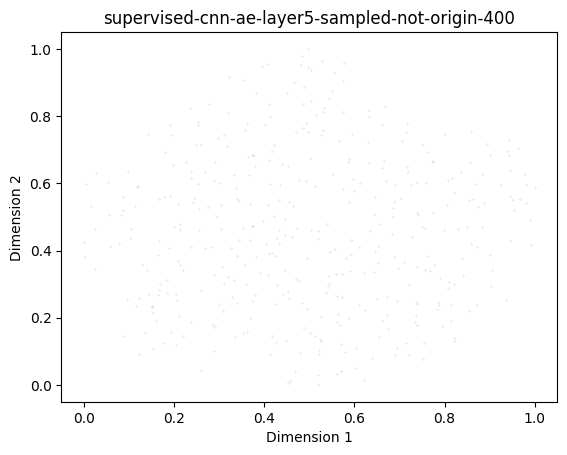

进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([400, 1000])
torch.Size([400])
sampling_number: 400, k_nearst: 5, Inception Score: 7.90826416015625
fid_model load success!


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 400, k_nearst: 5, fid_value: 71.09159936291593
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([400, 1000])
torch.Size([400])
sampling_number: 400, k_nearst: 20, Inception Score: 8.41200065612793
fid_model load success!


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 400, k_nearst: 20, fid_value: 70.3788335084808
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([400, 1000])
torch.Size([400])
sampling_number: 400, k_nearst: 100, Inception Score: 8.571283340454102
fid_model load success!


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 400, k_nearst: 100, fid_value: 69.56339654525658
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([400, 1000])
torch.Size([400])
sampling_number: 400, k_nearst: 50000, Inception Score: 8.011883735656738
fid_model load success!


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 400, k_nearst: 50000, fid_value: 70.28696822021169
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##################################################
采样后的长度： 1600


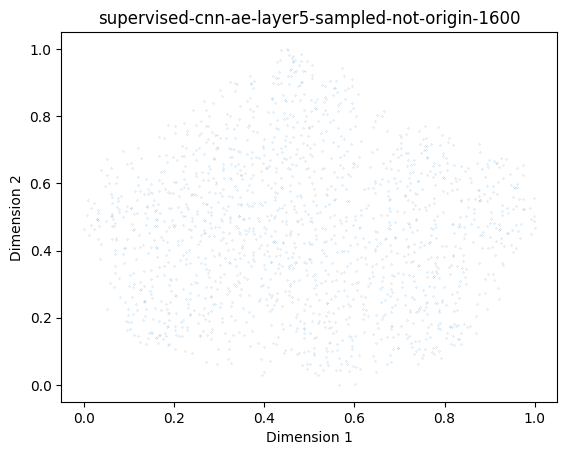

进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([1600, 1000])
torch.Size([1600])
sampling_number: 1600, k_nearst: 5, Inception Score: 8.939005851745605
fid_model load success!


100%|██████████| 16/16 [00:02<00:00,  7.60it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 1600, k_nearst: 5, fid_value: 26.066385729069168
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([1600, 1000])
torch.Size([1600])
sampling_number: 1600, k_nearst: 20, Inception Score: 8.814013481140137
fid_model load success!


100%|██████████| 16/16 [00:02<00:00,  7.42it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 1600, k_nearst: 20, fid_value: 24.37839484044281
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([1600, 1000])
torch.Size([1600])
sampling_number: 1600, k_nearst: 100, Inception Score: 8.988662719726562
fid_model load success!


100%|██████████| 16/16 [00:02<00:00,  7.60it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 1600, k_nearst: 100, fid_value: 22.8833250754015
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([1600, 1000])
torch.Size([1600])
sampling_number: 1600, k_nearst: 50000, Inception Score: 8.458032608032227
fid_model load success!


100%|██████████| 16/16 [00:02<00:00,  7.58it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 1600, k_nearst: 50000, fid_value: 22.001555276040506
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##################################################
采样后的长度： 3600


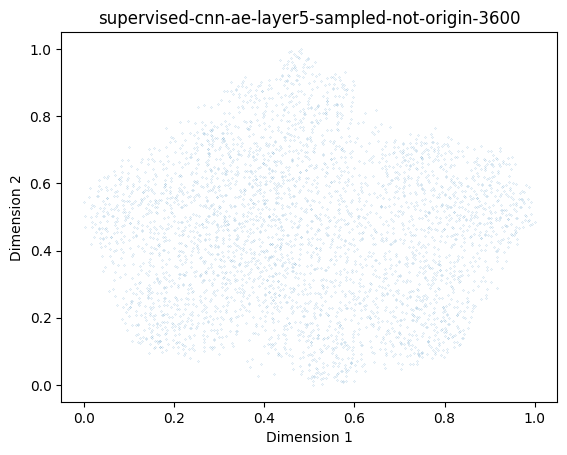

进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([3600, 1000])
torch.Size([3600])
sampling_number: 3600, k_nearst: 5, Inception Score: 8.393712043762207
fid_model load success!


100%|██████████| 36/36 [00:04<00:00,  8.70it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 3600, k_nearst: 5, fid_value: 15.35793910749112
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([3600, 1000])
torch.Size([3600])
sampling_number: 3600, k_nearst: 20, Inception Score: 8.612289428710938
fid_model load success!


100%|██████████| 36/36 [00:04<00:00,  8.87it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 3600, k_nearst: 20, fid_value: 13.657754124743292
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([3600, 1000])
torch.Size([3600])
sampling_number: 3600, k_nearst: 100, Inception Score: 8.449633598327637
fid_model load success!


100%|██████████| 36/36 [00:04<00:00,  8.80it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 3600, k_nearst: 100, fid_value: 12.209291633096768
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([3600, 1000])
torch.Size([3600])
sampling_number: 3600, k_nearst: 50000, Inception Score: 8.448445320129395
fid_model load success!


100%|██████████| 36/36 [00:04<00:00,  8.84it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 3600, k_nearst: 50000, fid_value: 11.052070913830448
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##################################################
采样后的长度： 6400


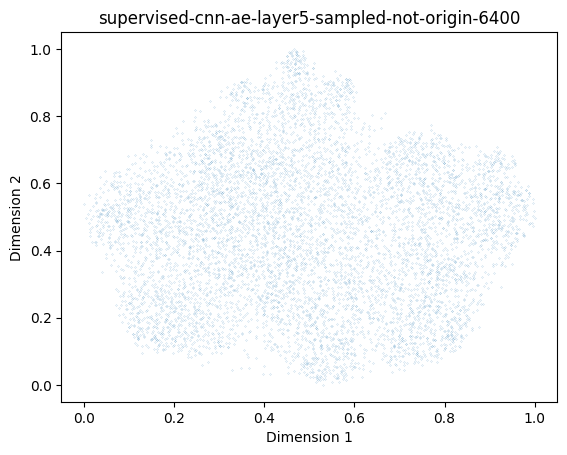

进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([6400, 1000])
torch.Size([6400])
sampling_number: 6400, k_nearst: 5, Inception Score: 8.726142883300781
fid_model load success!


100%|██████████| 64/64 [00:06<00:00,  9.28it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 6400, k_nearst: 5, fid_value: 12.075639554902011
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([6400, 1000])
torch.Size([6400])
sampling_number: 6400, k_nearst: 20, Inception Score: 8.718082427978516
fid_model load success!


100%|██████████| 64/64 [00:07<00:00,  9.14it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 6400, k_nearst: 20, fid_value: 10.40604316056374
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([6400, 1000])
torch.Size([6400])
sampling_number: 6400, k_nearst: 100, Inception Score: 8.81480884552002
fid_model load success!


100%|██████████| 64/64 [00:06<00:00,  9.28it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 6400, k_nearst: 100, fid_value: 8.774322148736019
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([6400, 1000])
torch.Size([6400])
sampling_number: 6400, k_nearst: 50000, Inception Score: 8.68259334564209
fid_model load success!


100%|██████████| 64/64 [00:06<00:00,  9.34it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 6400, k_nearst: 50000, fid_value: 7.587155333138412
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##################################################
采样后的长度： 10000


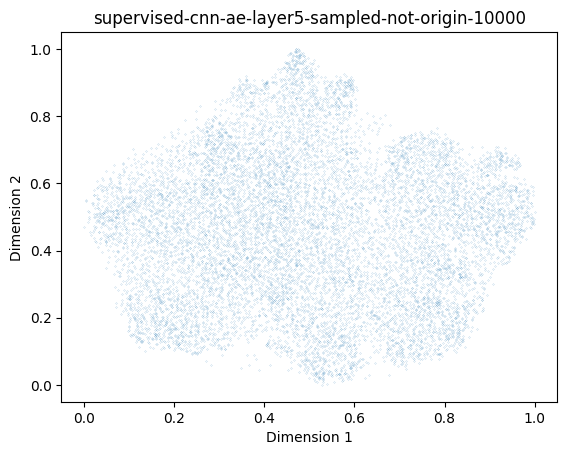

进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([10000, 1000])
torch.Size([10000])
sampling_number: 10000, k_nearst: 5, Inception Score: 8.96542739868164
fid_model load success!


100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 10000, k_nearst: 5, fid_value: 10.573118562697857
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([10000, 1000])
torch.Size([10000])
sampling_number: 10000, k_nearst: 20, Inception Score: 8.855422973632812
fid_model load success!


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 10000, k_nearst: 20, fid_value: 8.9794834493199
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~
生成图片中。。。。
图片生成完成。。。。
predictions.shape:  torch.Size([10000, 1000])
torch.Size([10000])
sampling_number: 10000, k_nearst: 100, Inception Score: 8.685098648071289
fid_model load success!


100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
sampling_number: 10000, k_nearst: 100, fid_value: 7.262010034490459
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
进入了防止粘在一块~~~~~~~~~~~~~~~~~~


In [72]:
# 打网格的密度采样，不再是从原始数据集中获取子集，而是采取新的坐标点
class density_based_latent_space_sampling():
    def __init__(self, sampling_number=50000, grid_size=100):
            super(density_based_latent_space_sampling, self).__init__()
            '''
                sampling_number：采样的数量
                grid_size：划分网格（grid_size*grid_size）
            '''
            self.sampling_number = sampling_number
            self.grid_size = grid_size
            return

    # 采样
    def sample(self, data):
        '''
            注意data是归一化后的2维坐标数据：[0, 1] × [0, 1]
        '''

        # 获取数据样本数量
        n = data.shape[0]
        
        # 构建网格，返回每个网格中的样本数量，以及样本下标
        grid_count, grid_indexes = self._construct_grids(data, self.grid_size)

        # 计算每个网格的采样数量
        sample_count = np.ceil(grid_count * self.sampling_number / n).astype(int)

        # 统计非空网格的数量
        non_empty_grids = np.sum(sample_count > 0)

        # 计算每个网格最大代表密度(这个乘以2好像就是为了扩大一下差异，经验数值，来自gpt)
        max_represneted_density = int(self.sampling_number * 2 / non_empty_grids)

        # 统计每个代表密度级别的网格数量(返回一个数组，其长度等于grid_count中元素最大值加1，每个元素值则是它当前索引值在grid_count中出现的次数)
        density_count = np.bincount(grid_count.reshape(-1))

        # 计算密度级别之间的间隔
        k = non_empty_grids / max_represneted_density

        tmp = 0 # 用于临时计数
        next_milestone = k # 下一个密度里程碑
        flag = True # 标记是否需要增加密度级别
        tmp_density = 1 # 当前密度级别
        density_to_represent = [0] # 特定数据含量的网格所代表的密度级别
        for grid_this_density in density_count[1:]:
            # if grid_this_density == 0:
            #     density_to_represent.append(-1)
            #     continue
            # 如果当前密度级别的网格数量加上当前计数小于等于下一个里程碑，则将当前密度级别添加到密度代表列表中
            if tmp + grid_this_density <= next_milestone:
                density_to_represent.append(tmp_density)
                flag = False
            else:
                # 如果下一个里程碑减去当前计数大于当前计数加上当前密度级别的网格数量减去下一个里程碑，或者flag为True，则将当前密度级别添加到密度代表列表中
                if next_milestone - tmp > tmp + grid_this_density - next_milestone or flag:
                    density_to_represent.append(tmp_density)
                    tmp_density += 1
                    flag = True
                else:
                    tmp_density += 1
                    density_to_represent.append(tmp_density)
                    flag = False
                next_milestone += k
            tmp += grid_this_density

        all_coordinates = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if grid_count[i][j] > 0:
                    # 从当前网格中根据密度级别随机生成数据
                    x_min, x_max = i*1/self.grid_size, (i+1)/self.grid_size
                    y_min, y_max = j*1/self.grid_size, (j+1)/self.grid_size
                    # 生成随机二维坐标数组
                    coordinates = np.random.uniform(low=[x_min, y_min], high=[x_max, y_max], size=(density_to_represent[grid_count[i][j]], 2))
                    all_coordinates.append(coordinates)
        
        all_coordinates = np.concatenate(all_coordinates, axis=0)
        return all_coordinates

    # 构建网格
    def _construct_grids(self, data, grid_size):
        '''
            返回值：
            grid_count：统计每个网格中的样本数量
            grid_indexes：记录每个网格中的样本的下标
        '''
        # 代码将输入数据乘以grid_size并转换为整数类型，得到离散化的数据discrete_full_data。这样做的目的是将数据映射到网格的坐标空间上。
        discrete_full_data = (data * grid_size).astype(int)
        # 通过np.where函数找到位于网格边界的数据点，并将其坐标减去1。这是为了保证所有数据点都在网格范围内，避免越界。
        discrete_full_data[np.where(discrete_full_data == grid_size)] -= 1
        # 代码创建了两个空数组：grid_count和grid_indexes。grid_count是一个大小为(grid_size, grid_size)的二维数组，用于统计每个网格中的数据点数量。grid_indexes是一个嵌套的二维列表，用于存储每个网格中数据点的索引。
        grid_count = np.zeros((grid_size, grid_size)).astype(int)
        grid_indexes = [[[] for _ in range(grid_size)] for __ in range(grid_size)]
        
        for k, single_data in enumerate(discrete_full_data):
            grid_count[single_data[0], single_data[1]] += 1
            grid_indexes[single_data[0]][single_data[1]].append(k)
        return grid_count, grid_indexes

# 打网格的密度采样，简化版本
class density_based_latent_space_sampling_simply():
    def __init__(self, sampling_number=50000, grid_size=100):
            super(density_based_latent_space_sampling_simply, self).__init__()
            '''
                sampling_number：采样的数量
                grid_size：划分网格（grid_size*grid_size）
            '''
            self.sampling_number = sampling_number
            self.grid_size = grid_size
            return

    # 采样
    def sample(self, data):
        '''
            注意data是归一化后的2维坐标数据：[0, 1] × [0, 1]
        '''

        # 获取数据样本数量
        n = data.shape[0]
        
        # 构建网格，返回每个网格中的样本数量，以及样本下标
        grid_count, grid_indexes = self._construct_grids(data, self.grid_size)

        # 计算每个网格的采样数量
        sample_count = np.ceil(grid_count * self.sampling_number / n).astype(int)

        all_coordinates = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if grid_count[i][j] > 0:
                    # 从当前网格中根据密度级别随机生成数据
                    x_min, x_max = i*1/self.grid_size, (i+1)/self.grid_size
                    y_min, y_max = j*1/self.grid_size, (j+1)/self.grid_size
                    # 生成随机二维坐标数组
                    coordinates = np.random.uniform(low=[x_min, y_min], high=[x_max, y_max], size=(sample_count[i][j], 2))
                    all_coordinates.append(coordinates)
        
        all_coordinates = np.concatenate(all_coordinates, axis=0)
        return all_coordinates

    # 构建网格
    def _construct_grids(self, data, grid_size):
        '''
            返回值：
            grid_count：统计每个网格中的样本数量
            grid_indexes：记录每个网格中的样本的下标
        '''
        # 代码将输入数据乘以grid_size并转换为整数类型，得到离散化的数据discrete_full_data。这样做的目的是将数据映射到网格的坐标空间上。
        discrete_full_data = (data * grid_size).astype(int)
        # 通过np.where函数找到位于网格边界的数据点，并将其坐标减去1。这是为了保证所有数据点都在网格范围内，避免越界。
        discrete_full_data[np.where(discrete_full_data == grid_size)] -= 1
        # 代码创建了两个空数组：grid_count和grid_indexes。grid_count是一个大小为(grid_size, grid_size)的二维数组，用于统计每个网格中的数据点数量。grid_indexes是一个嵌套的二维列表，用于存储每个网格中数据点的索引。
        grid_count = np.zeros((grid_size, grid_size)).astype(int)
        grid_indexes = [[[] for _ in range(grid_size)] for __ in range(grid_size)]
        
        for k, single_data in enumerate(discrete_full_data):
            grid_count[single_data[0], single_data[1]] += 1
            grid_indexes[single_data[0]][single_data[1]].append(k)
        return grid_count, grid_indexes

import math
for sampling_number in [400, 1600, 3600, 6400, 10000, 50000]:
    print("#"*50)
    # 画图展示
    origin_sample = density_based_latent_space_sampling_simply(sampling_number=sampling_number, grid_size=int(min(math.sqrt(sampling_number), 100)))
    sampled_coordinates = origin_sample.sample(zs_np)
    sampled_index = np.random.choice(len(sampled_coordinates), sampling_number, replace=False)
    sampled_coordinates = sampled_coordinates[sampled_index]
    print("采样后的长度：", len(sampled_coordinates))

    sampled_zs_np = sampled_coordinates

    title = f"supervised-cnn-ae-layer5-sampled-not-origin-{sampling_number}"

    # 进行归一化到[0,1]*[0,1]
    min_val = np.min(sampled_zs_np, axis=0)
    max_val = np.max(sampled_zs_np, axis=0)
    sampled_zs_np = (sampled_zs_np - min_val) / (max_val - min_val) 

    # 获取类别数量和颜色映射
    color_map = plt.get_cmap("tab10")

    # 绘制散点图
    plt.scatter(sampled_zs_np[:, 0], sampled_zs_np[:, 1], s=0.01)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)

    plt.show()

    from scipy import spatial
    tree = spatial.KDTree(data=zs_np)

    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    import torchvision.utils as utils
    import numpy as np
    from scipy.stats import norm
    import torch

    model_files_dir = "./model_files/" # 模型位置
    sys.path.append(model_files_dir)
    import model_files as model_all

    import sys
    python_files_dir = "./python_files/" # python工具包位置
    sys.path.append(python_files_dir)
    import fid_score as official_fid


    # 最开始的版本，就取近邻的向量进行插值，但是不对类的向量进行插值
    def get_zs_new_not_class(coordinates, kdTree_2D, latent_z, k=5):
        '''
        coordinates: n个要插值的坐标
        kdTree_2D: 降维后的2D坐标
        latent_z: 生成模型的输入潜向量，和kdTree_2D是一一对应关系
        k: 近邻的数量
        '''
        print("最开始的版本，优化了一下代码~~~~~~~~~~~ k:",k)
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k) #这里的k为固定值
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        
        for iter in range(len(coordinates)):
            iter_distance = nearest_distance[iter]
            iter_index = nearest_index[iter]
            
            sum_distanceForIter = np.sum(iter_distance) #这k个近邻的距离总和
            for i, index in enumerate(iter_index):
                temp_z = latent_z[index].clone().detach()
                temp_distance = iter_distance[i]
                w = (sum_distanceForIter-temp_distance)/((k-1)*sum_distanceForIter) #对z进行权重
                if i == 0:
                    z = temp_z*w
                else:
                    z += temp_z*w

            z[-128:] = latent_z[iter_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量

            z = z.unsqueeze(0) # shape:[1*latent_dim]
            if iter == 0:
                zs = z
            else:
                zs = torch.cat((zs, z), dim=0)
            # print(zs.shape)
        return zs

    # 插值函数(kjl的防止粘贴函数)
    def get_zs_prevent_stick_not_class(coordinates, kdTree_2D, latent_z, k=20):
        '''
        nearest_distance: n*k维
        nearest_index: n*k维
        dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
        '''
        print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~")
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for i, pos in enumerate(coordinates): #对每一个坐标进行插值
            # pos坐标对应的近邻下标
            pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
            pos_nearst_distance = nearest_distance[i]

            # 最近邻的坐标点，以及最近的距离
            most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
            most_nearst_dis = pos_nearst_distance[0]

            # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
            s1 = most_nearst_dis
            best_index = 1 # 默认第二个最近邻最好
            min_dif = 100
            for j in range(1, k):
                cur_pos = origin_coordinates[pos_nearst_index[j]]
                s2 = pos_nearst_distance[j]
                s3 = np.linalg.norm(most_nearst_pos-cur_pos)
                if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                    min_dif = (s1 + s2) - s3
                    best_index = j
            
            temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
            temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
            sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
            z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

            z_new[-128:] = latent_z[pos_nearst_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量
            z_new = z_new.unsqueeze(0)
            if i == 0:
                zs = z_new
            else:
                zs = torch.cat((zs, z_new), dim=0)

        return zs

    # 插值函数，最远最近插值方法
    def get_zs_farthest_and_closeet(coordinates, kdTree_2D, latent_z, k=50000):
        '''
        nearest_distance: n*k维
        nearest_index: n*k维
        dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
        '''
        print("进入了最远最近采样~~~~~~~~~~~~~~~~~~")
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for i, pos in enumerate(coordinates): #对每一个坐标进行插值
            # pos坐标对应的近邻下标
            pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
            pos_nearst_distance = nearest_distance[i]

            # 最近邻的距离
            most_nearst_dis = pos_nearst_distance[0]

            # 最远点的的距离
            most_farthest_dis = pos_nearst_distance[-1]

            temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
            temp_z_1 = latent_z[pos_nearst_index[-1]].clone().detach()
            sum_distance = most_nearst_dis + most_farthest_dis
            z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-most_farthest_dis)/(sum_distance) * temp_z_1

            z_new = z_new.unsqueeze(0)
            if i == 0:
                zs = z_new
            else:
                zs = torch.cat((zs, z_new), dim=0)

        return zs

    # 插值函数，反距离权重插值，不对类别进行插值
    def get_zs_idw_not_class(coordinates, kdTree_2D, latent_z, k=2, p=50):
        '''
        nearest_distance: n*k维
        nearest_index: n*k维
        dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
        '''
        print("进入了反距离权重插值，不对类别进行插值（Inverse Distance Weighting, IDW）~~~~~~~~~~~~~~~~~~")
        # 直接一次查询所有坐标的k个近邻
        nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
        origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
        for i, pos in enumerate(coordinates): #对每一个坐标进行插值
            # pos坐标对应的近邻下标
            pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
            pos_nearst_distance = nearest_distance[i]
            weights = torch.tensor(1.0 / (pos_nearst_distance + 1e-8)) # 避免除以零，加上一个小的常数

            # 计算加权平均
            weighted_values = latent_z[pos_nearst_index].clone().detach() * weights[:, None] ** p
            z_new = torch.sum(weighted_values, dim=0) / torch.sum(weights**p)
            

            z_new[-128:] = latent_z[pos_nearst_index[0]][-128:].clone().detach()   #类向量为最近的那一个点的向量
            z_new = z_new.unsqueeze(0)
            if i == 0:
                zs = z_new
            else:
                zs = torch.cat((zs, z_new), dim=0)

        return zs

    # 用来处理zs的类，方便使用batchsize
    class My_2D_zs_data_sets(Dataset):
        def __init__(self, zs):
            super(My_2D_zs_data_sets, self).__init__()
            self.zs = zs

        def __getitem__(self, index):
            z = self.zs[index]
            return z

        def __len__(self):
            return len(self.zs)

    # 删除已有数据
    def  del_file(path):
        if not os.listdir(path):
            print('目录为空！')
        else:
            for i in os.listdir(path):
                path_file = os.path.join(path,i)  #取文件绝对路径
                if os.path.isfile(path_file):
                    os.remove(path_file)
                else:
                    del_file(path_file)
                    shutil.rmtree(path_file)

    # 数据集
    new_coords = sampled_coordinates
    kdTree = tree
    latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
    latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错

    for i in range(4):
        if i == 0:
            k_nearst = 5
        elif i == 1:
            k_nearst = 20
        elif i == 2:
            k_nearst = 100
        elif i == 3:
            k_nearst = 50000

        zs_2D = get_zs_prevent_stick_not_class(new_coords, kdTree, latent_z, k=k_nearst)
        zs_datasets = My_2D_zs_data_sets(zs_2D)
        zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)


        checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
        G = model_all.get_generative_model("CIFAR10").to(device)
        G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
        G.eval()

        save_pic_path = "./临时垃圾-随时可删/2D_png/"
        del_file(save_pic_path)

        first = 0 # 判断是否第一次进入循环
        count = 0
        print("生成图片中。。。。")
        with torch.no_grad(): # 取消梯度计算，加快运行速度
            for batch_z in zs_loader: 
                z = batch_z.clone().to(torch.float32).to(device)    # latent code
                imgs = G(z)   
                for i, img in enumerate(imgs):
                    img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
                    utils.save_image(img.detach().cpu(), save_pic_path + f'pic_{count}.png')
                    count += 1
        print("图片生成完成。。。。")

        # 使用inception_v3获取
        from torchvision.models import inception_v3
        from torch.utils.data import DataLoader
        import torch.nn.functional as F

        # 加载预训练的Inception模型
        inception_model = inception_v3(pretrained=True, transform_input=False).eval()
        device = torch.device("cuda:1")
        inception_model.to(device)


        # 生成的图像数据集（假设你有一个名为generated_data的数据集）
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        generated_dataset = My_pics_data_sets(path=save_pic_path,transform=transform)
        generated_dataloader = DataLoader(generated_dataset, batch_size=32, shuffle=True)

        # 计算预测分数
        predictions = []
        for images, ids in generated_dataloader:
            images = images.to(device)
            with torch.no_grad():
                images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
                preds = inception_model(images)
            predictions.append(torch.softmax(preds, dim=1))

        predictions = torch.cat(predictions, dim=0)
        print("predictions.shape: ", predictions.shape)

        fake_probs = predictions
        # fake_probs.mean(dim=0, keepdim=True).shape
        # 计算Inception Score
        kl_divergence = (fake_probs * (fake_probs / fake_probs.mean(dim=0, keepdim=True)).log()).sum(dim=1)
        print(kl_divergence.shape)
        inception_score = torch.exp(kl_divergence.mean()).item()
        print(f"sampling_number: {sampling_number}, k_nearst: {k_nearst}, Inception Score: {inception_score}")

        # fid计算模型
        dims = 2048
        batch_size = 1
        num_avail_cpus = len(os.sched_getaffinity(0))
        num_workers = min(num_avail_cpus, 8)
        block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
        fid_model = official_fid.InceptionV3([block_idx], normalize_input=False).to(device)
        # fid_model = official_fid.InceptionV3([block_idx]).to(device)
        print('fid_model load success!')


        pic_path_fid1 = './static/data/CIFAR10/pic/origin_50k_png'
        pic_path_fid2 = save_pic_path

            
        batch_size = 100
        m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                            dims, device, num_workers)
        m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                            dims, device, num_workers)
        fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
        print(f"sampling_number: {sampling_number}, k_nearst: {k_nearst}, fid_value: {fid_value}")
        print("~"*50)